# CITS4404 Project (Sem 2 2020)

## Members
* Mark Gabriel (22210681)
* Ho Ho Ho (22634764)
* Tom Wakefield (23142374)
* Muhammad Marzuki Muhammad Kamal (22648619)

## Description

We aim to implement a GAN that takes element types as input and outputs a new Pokemon image, AKA a conditional GAN. 

## References: 
 * Conditional GAN: https://arxiv.org/abs/1411.1784
 * StackGAN: https://arxiv.org/abs/1612.03242
 * Wasserstein GAN: https://arxiv.org/abs/1701.07875
 * Improved training of Wasserstein GANs: https://arxiv.org/pdf/1704.00028.pdf
 * Transferring GANs: generating images from limited data: https://openaccess.thecvf.com/content_ECCV_2018/papers/yaxing_wang_Transferring_GANs_generating_ECCV_2018_paper.pdf

In [32]:
# import required libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import math
from os import path
import time

%matplotlib inline
timestr = time.strftime("%Y%m%d-%H%M")


# Data setup

Download the repo containing the images and the data into the current session from GitHub.

In [2]:
!rm -r pokemon-type-gan
!git clone https://github.com/markangelogabriel/pokemon-type-gan.git

rm: cannot remove 'pokemon-type-gan': No such file or directory
Cloning into 'pokemon-type-gan'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 1808 (delta 12), reused 24 (delta 9), pack-reused 1781
Receiving objects: 100% (1808/1808), 672.38 MiB | 28.66 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (1674/1674), done.


Then load the images.

In [3]:
import glob
data_dir = '/content/pokemon-type-gan/data'
image_dir = data_dir+'/pokemon_jpg/all'
all_images = glob.glob(image_dir + '/*')

In [4]:
pokemon_type_df = pd.read_csv(data_dir+'/pokemon.csv')
pokemon_type_df.head()

,PNG_Filename,JPG_Filename,Unique_ID,Unique_Name,Name_withDuplicates,PokeNum_withDuplicates,Primary,Secondary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,1.png,1.jpg,1,Bulbasaur,Bulbasaur,1,Grass,Poison,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2.png,2.jpg,2,Ivysaur,Ivysaur,2,Grass,Poison,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,3.png,3.jpg,3,Venusaur,Venusaur,3,Grass,Poison,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,3-mega.png,3-mega.jpg,3-mega,Venusaur-mega,Venusaur,3,Grass,Poison,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,4.png,4.jpg,4,Charmander,Charmander,4,Fire,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
annot_map = {}
binary_to_type = {}
label_map = {}
inverse_label_map = {}
index = 0 
for image in all_images:
    #image : path of an image
    image_name = image.split('/')[-1]
    #image_name: file name of the image
    #one_hot_type: type of a pokemon, representing by one-hot-encoding lables
    one_hot_type = list(pokemon_type_df[pokemon_type_df['JPG_Filename'] == image_name].iloc[0,8:29])
    #annot_map:{ file_name: one hot encoder type}
    annot_map[image_name] = one_hot_type
    #convert the binary serial of one-hot-encoding labels into decimical 
    decimical = int(''.join(str(num) for num in one_hot_type),2)
    #each pokemon can has 1 or 2 types
    type1 = list((pokemon_type_df[pokemon_type_df['JPG_Filename'] == image_name].Primary))[0]
    type2 = list((pokemon_type_df[pokemon_type_df['JPG_Filename'] == image_name].Secondary))[0]
    #if a pokemon has two type: add both types, else just the first type
    #binary_to_type: {decimical sum of the one-hot-encoding labels: type of pokemon}
    if type(type2) != float:
      binary_to_type[decimical] = (type1,type2)
    else:
      binary_to_type[decimical] = (type1)
    #label_map: {decimical sum of the one-hot-encoding labels: assigned number}
    #inverse_llabel_map: {assigned number: decimical sum of the one-hot-encoding labels}
    #label_map store each unique combination of existing pokemon types
    if decimical not in list(label_map.keys()):

      label_map[decimical] = index
      inverse_label_map[index] = decimical
      index +=1


In [6]:
annot_map['1.jpg']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]

In [7]:
from PIL import Image

class PokemonDataset(torch.utils.data.Dataset):
    
    def __init__(self,all_images,annot_map,transform):
        self.all_images=all_images
        self.annot_map = annot_map
        self.label_map = label_map
        self.transform=transform
        
    def __getitem__(self,idx):
        #impath: path of one image
        impath=self.all_images[idx]
        #open that image
        image=Image.open(impath)
        image = image.resize((64,64), Image.ANTIALIAS)
        
        # getting annotations for the image
        annotkey=impath.split("/")[-1] #.split(".")[0] 
        annot = self.annot_map[annotkey]
      
        #indices of 1 in annot
        indices = [ii for ii, xx in enumerate(annot ) if xx == 1]
       
        #pokemon has 18 atributes
        label = torch.zeros(18)
        if len(indices) > 1:
          label[indices[0]] = 1
          label[indices[1]] = 1
        else:
          label[indices[0]] = 1
        
        return self.transform(image),label
        
    def __len__(self):
        return len(self.all_images)

In [8]:
transform=transforms.Compose([
                                   transforms.Resize(64), #Images resized from 256x256 to 64x64 due to performance issues and maximum CUDA usage from Colab's side
                                   transforms.RandomHorizontalFlip(), # Data augmentation to effectively double the number of images
                                   transforms.RandomRotation(10, fill=(255,255,255)), # More data augmentation
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalise data on scale: [-1,1]
                               ])

pokemon_images= PokemonDataset(all_images,annot_map,transform=transform)

In [9]:
batch_size=16

data_loader = torch.utils.data.DataLoader(dataset=pokemon_images,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

In [10]:
def label_to_str(label):
  label = label.tolist()
  #convert from binary number to decimical number
  decimical = int(''.join(str(int(num)) for num in label),2)
  str_label = binary_to_type[decimical]
  return str_label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

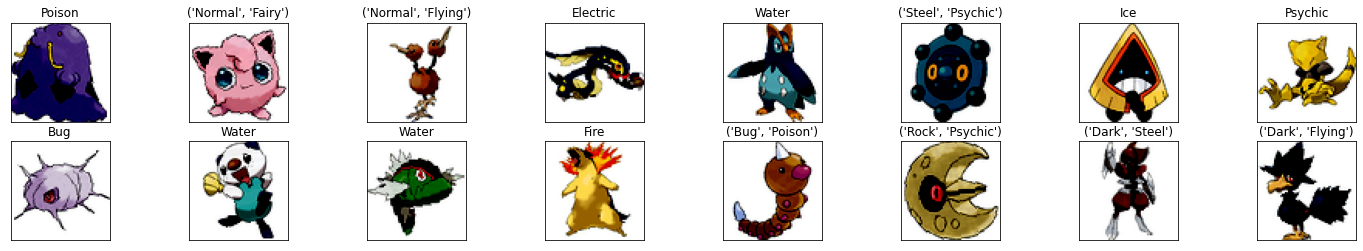

In [11]:
dataiter = iter(data_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    label = label_to_str(labels[idx])
    ax.set_title(label)

In [12]:
labels.shape

torch.Size([16, 18])

# GAN setup

In [13]:
# Number of channels in the images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

unique_types  = len(set(binary_to_type.keys())) #133

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()

        self.ylabels = nn.Sequential(
            nn.Linear(18,64*64*1),
            nn.ReLU(True)
        ) # no. of labels, batch size

        self.main = nn.Sequential(
            # input is 3+1 x 64 x 64
            nn.Conv2d(nc +1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),
            # state size. 512 x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input,labels):

        yy=self.ylabels(labels)
        yy = yy.view(-1,1,64,64)
        combined = torch.cat([input,yy],1)
        
        output = self.main(combined)
        
        return output.view(-1, 1).squeeze(1)

netD = Discriminator(ndf,nc).to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (ylabels): Sequential(
    (0): Linear(in_features=18, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11):

In [16]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #1200 = 1000+200
            nn.ConvTranspose2d(nz+18, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(ngf * 2,  ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self,noise,labels):

        combined = torch.cat([noise,labels],1)
        output = self.main(combined.view(-1, nz+18, 1, 1))

        return output

netG = Generator(nz,ngf,nc).to(device)
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(118, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# GAN Hyper-parameters

In [42]:
# params suggested to be good in the DCGAN paper 
# GANs can be very seinsitive to small changes in parameter values
# Check out some options in the DCGAN paper:
#    https://arxiv.org/pdf/1511.06434.pdf
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# training hyperparams
num_epochs = 900
print_every = 300
import random
random.seed(10)
# Get some fixed data for evaluating the model's performance as we train
fixed_noise = torch.randn(batch_size, nz, device=device)

fixed_labels = []

for ii in range(batch_size):
  fixed_label = list(np.zeros(18))
  temp = random.randint(0,17)
  fixed_label[temp] = 1
  #second type of a pokemon
  if random.random() > random.random():
    temp = random.randint(0,17)
    fixed_label[temp] = 1
  fixed_labels.append(fixed_label)
  
#torch.cat([fixed_labels,fixed_label],1)
#fixed_labels = fixed_labels.to(device)
fixed_labels = torch.Tensor(fixed_labels).to(device)
real_label = 1
fake_label = 0

# Create optimizers for the discriminator and generator
optimizerD = optim.Adam(netD.parameters(), lr, [beta1, beta2])
optimizerG = optim.Adam(netG.parameters(), lr, [beta1, beta2])

criterion = nn.BCELoss()

#Load Model

In [43]:
# # If model exists, load it
# model available at epochs: 900, 1800, 2700, 3600, 4500, 5400

model_epoch = 1800
D_PATH = '/content/pokemon-type-gan/models/CGAN/netd_model_' + str(model_epoch) + '.pth'
G_PATH = '/content/pokemon-type-gan/models/CGAN/netg_model_' + str(model_epoch) + '.pth'

#Training

In [44]:
# ask the user whether resuming training or not
answer = input('Select from options: \n[1] Load Model \n[2] Continue training from checkpoint?\n[3] Train new model \n ')

if answer == '1':
  if(path.exists(D_PATH) & path.exists(G_PATH)):
    # load the model checkpoint
    checkpointD = torch.load(D_PATH)
    checkpointG = torch.load(G_PATH)
    # load model weights state_dict
    netD.load_state_dict(checkpointD['model_state_dict'])
    netG.load_state_dict(checkpointG['model_state_dict'])
    # load trained optimizer state_dict
    optimizerD.load_state_dict(checkpointD['optimizer_state_dict'])
    optimizerG.load_state_dict(checkpointG['optimizer_state_dict'])
    # load the criterion
    criterion = checkpointD['loss']

    print("Model loaded\n")


elif answer == '2':
  print("Continue training from checkpoint\n")

  # load the model checkpoint
  checkpointD = torch.load(D_PATH)
  checkpointG = torch.load(G_PATH)
  # load model weights state_dict
  netD.load_state_dict(checkpointD['model_state_dict'])
  netG.load_state_dict(checkpointG['model_state_dict'])
  # load trained optimizer state_dict
  optimizerD.load_state_dict(checkpointD['optimizer_state_dict'])
  optimizerG.load_state_dict(checkpointG['optimizer_state_dict'])
  # load the criterion
  criterion = checkpointD['loss']

  samples = []
  losses = []

  # train the network
  for epoch in range(num_epochs):
      for i_batch, data in enumerate(data_loader):
          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################

          # train with real
          netD.zero_grad()
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)

          binary_labels = data[1].to(device) 

          label = torch.full((b_size,), real_label*0.9,
                            dtype=real_cpu.dtype, device=device)

          output = netD(real_cpu,binary_labels)
          
          errD_real = criterion(output, label)
          errD_real.backward()
          D_x = output.mean().item()

          # train with fake
          noise = torch.randn(b_size, nz, device=device)
          fake = netG(noise,binary_labels)
          label.fill_(fake_label)
          output = netD(fake.detach(),binary_labels)
          errD_fake = criterion(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          optimizerD.step()

          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################

          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          output = netD(fake,binary_labels)
          errG = criterion(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()

          ############################
          # (3) Print some stats 
          ###########################
          if i_batch % print_every == 0:
              # append D loss and G loss
              losses.append((errD.item(), errG.item()))
              # print discriminator and generator loss
              print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                      epoch+1, num_epochs, errD.item(), errG.item()))

      
      # AFTER EACH EPOCH    
      # generate and save fake images
      netG.eval() # eval mode for generating samples
      # eval mode - batch_norm & drop out behave differently in generating new samples
      # batch_norm should use population statistics instead of batch statistics in eval
      # dropout should not drop any nodes during testing
      
      samples_z = netG(fixed_noise,fixed_labels)
      samples.append(samples_z)
      netG.train() # switch back to training mode

  # Training Loss Plot
  fig, ax = plt.subplots()
  losses = np.array(losses)
  plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
  plt.plot(losses.T[1], label='Generator', alpha=0.5)
  plt.title("Training Losses")
  plt.legend()

  # save model checkpoint
  torch.save({
              'epoch': num_epochs,
              'model_state_dict': netD.state_dict(),
              'optimizer_state_dict': optimizerD.state_dict(),
              'loss': criterion,
              }, '/content/pokemon-type-gan/models/CGAN/netd_model_' + timestr + '.pth')

  torch.save({
              'epoch': num_epochs,
              'model_state_dict': netG.state_dict(),
              'optimizer_state_dict': optimizerG.state_dict(),
              'loss': criterion,
              }, '/content/pokemon-type-gan/models/CGAN/netg_model_' + timestr + '.pth')

if answer == '3':
  print("Training new model")

  # reset model for new training
  netD = Discriminator(ndf,nc).to(device)
  netD.apply(weights_init)
  netG = Generator(nz,ngf,nc).to(device)
  netG.apply(weights_init)
  optimizerD = optim.Adam(netD.parameters(), lr, [beta1, beta2])
  optimizerG = optim.Adam(netG.parameters(), lr, [beta1, beta2])
  criterion = nn.BCELoss()

  samples = []
  losses = []

  # train the network
  for epoch in range(num_epochs):
      for i_batch, data in enumerate(data_loader):
          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################

          # train with real
          netD.zero_grad()
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)

          binary_labels = data[1].to(device) 

          label = torch.full((b_size,), real_label*0.9,
                            dtype=real_cpu.dtype, device=device)

          output = netD(real_cpu,binary_labels)
          
          errD_real = criterion(output, label)
          errD_real.backward()
          D_x = output.mean().item()

          # train with fake
          noise = torch.randn(b_size, nz, device=device)
          fake = netG(noise,binary_labels)
          label.fill_(fake_label)
          output = netD(fake.detach(),binary_labels)
          errD_fake = criterion(output, label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          optimizerD.step()

          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################

          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          output = netD(fake,binary_labels)
          errG = criterion(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()

          ############################
          # (3) Print some stats 
          ###########################
          if i_batch % print_every == 0:
              # append D loss and G loss
              losses.append((errD.item(), errG.item()))
              # print discriminator and generator loss
              print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                      epoch+1, num_epochs, errD.item(), errG.item()))

      
      # AFTER EACH EPOCH    
      # generate and save fake images
      netG.eval() # eval mode for generating samples
      # eval mode - batch_norm & drop out behave differently in generating new samples
      # batch_norm should use population statistics instead of batch statistics in eval
      # dropout should not drop any nodes during testing
      
      samples_z = netG(fixed_noise,fixed_labels)
      samples.append(samples_z)
      netG.train() # switch back to training mode

  # Training Loss Plot
  fig, ax = plt.subplots()
  losses = np.array(losses)
  plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
  plt.plot(losses.T[1], label='Generator', alpha=0.5)
  plt.title("Training Losses")
  plt.legend()

  # save model checkpoint
  torch.save({
              'epoch': num_epochs,
              'model_state_dict': netD.state_dict(),
              'optimizer_state_dict': optimizerD.state_dict(),
              'loss': criterion,
              }, '/content/pokemon-type-gan/models/CGAN/netd_model_' + timestr + '.pth')

  torch.save({
              'epoch': num_epochs,
              'model_state_dict': netG.state_dict(),
              'optimizer_state_dict': optimizerG.state_dict(),
              'loss': criterion,
              }, '/content/pokemon-type-gan/models/CGAN/netg_model_' + timestr + '.pth')

Select from options: 
[1] Load Model 
[2] Continue training from checkpoint?
[3] Train new model 
 1
Model loaded



# Training Results

In [20]:
# helper function for viewing a list of images, for us they are intermediate fake images
def view_samples2(samples, rows, cols, image_width, image_height):
    fig, axes = plt.subplots(figsize=(32,32), nrows=rows, ncols=cols, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((image_width,image_height,nc)))

## Showing all-type sample images

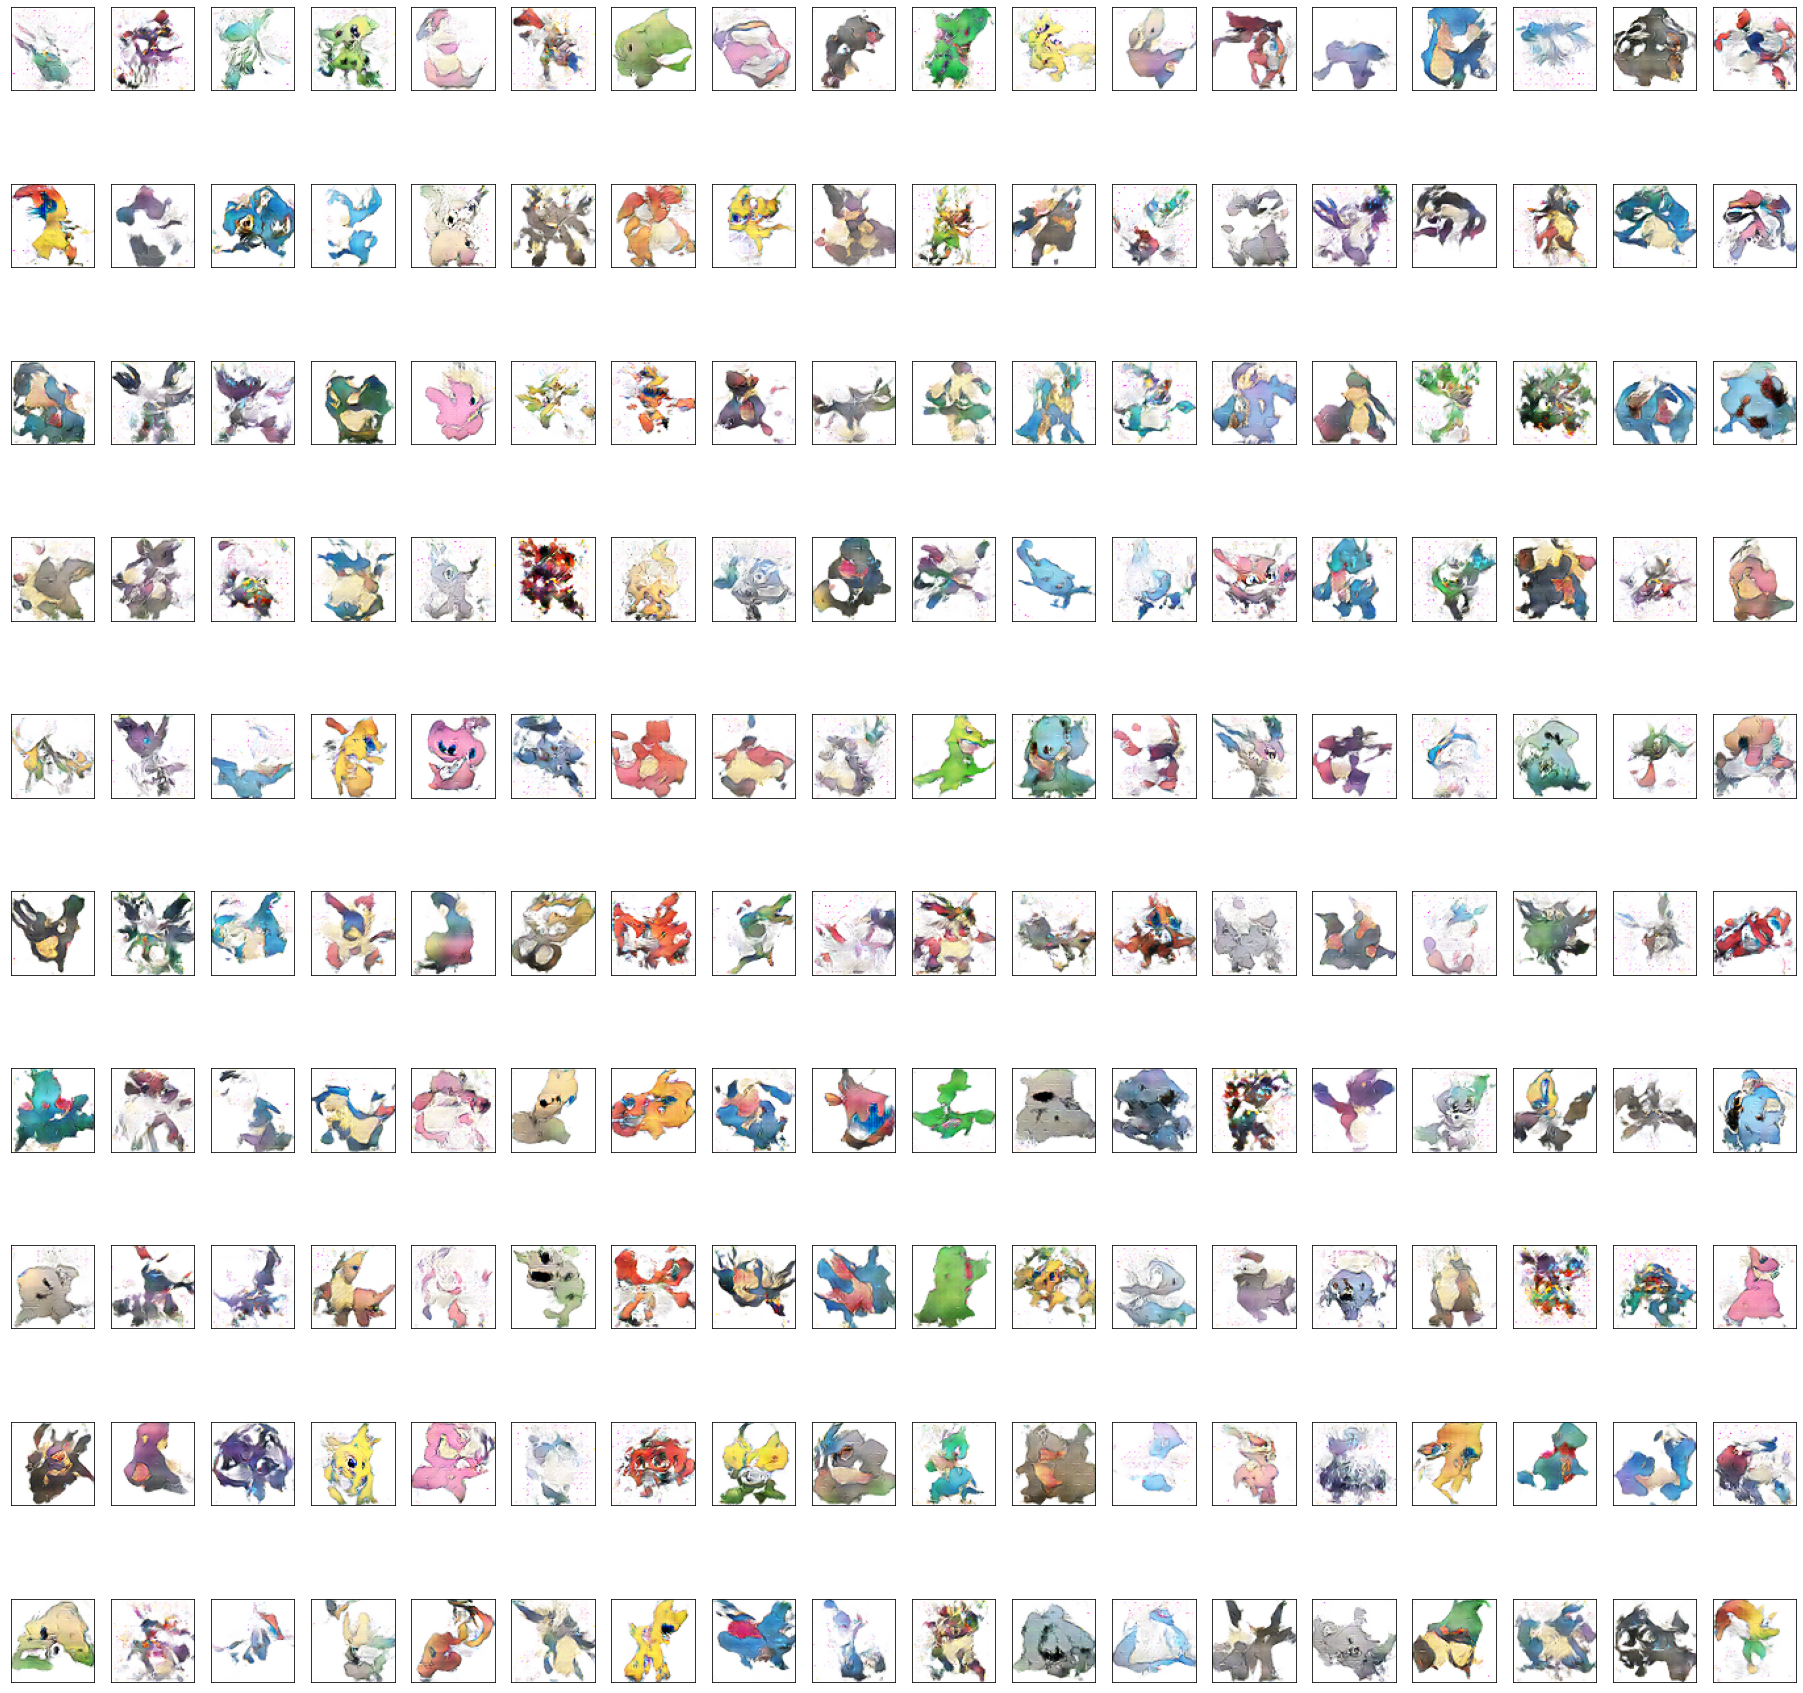

In [41]:
# Ploting genereated image for all type (Each column represent type 0-17)
# 0: Bug, 1: Dark, 2: Dragon, 3: Electric, 4: Fairy, 5: Fighting, 6: Fire, 7: Flying, 8: Ghost
# 9: Grass, 10: Ground, 11: Ice, 12: Normal, 13: Poison, 14: Psychic, 15: Rock, 16: Steel, 17: Water

all_noise = torch.randn(18*10, nz, device=device)
all_label = np.zeros((18, 18))
np.fill_diagonal(all_label, 1)
all_label = all_label.tolist()
all_label = torch.Tensor(all_label).to(device)
all_label = torch.cat(10*[all_label])
fake_all_images = netG(all_noise, all_label)

view_samples2(fake_all_images, 10, 18, ngf, ngf)

## Showing specific-type sample images

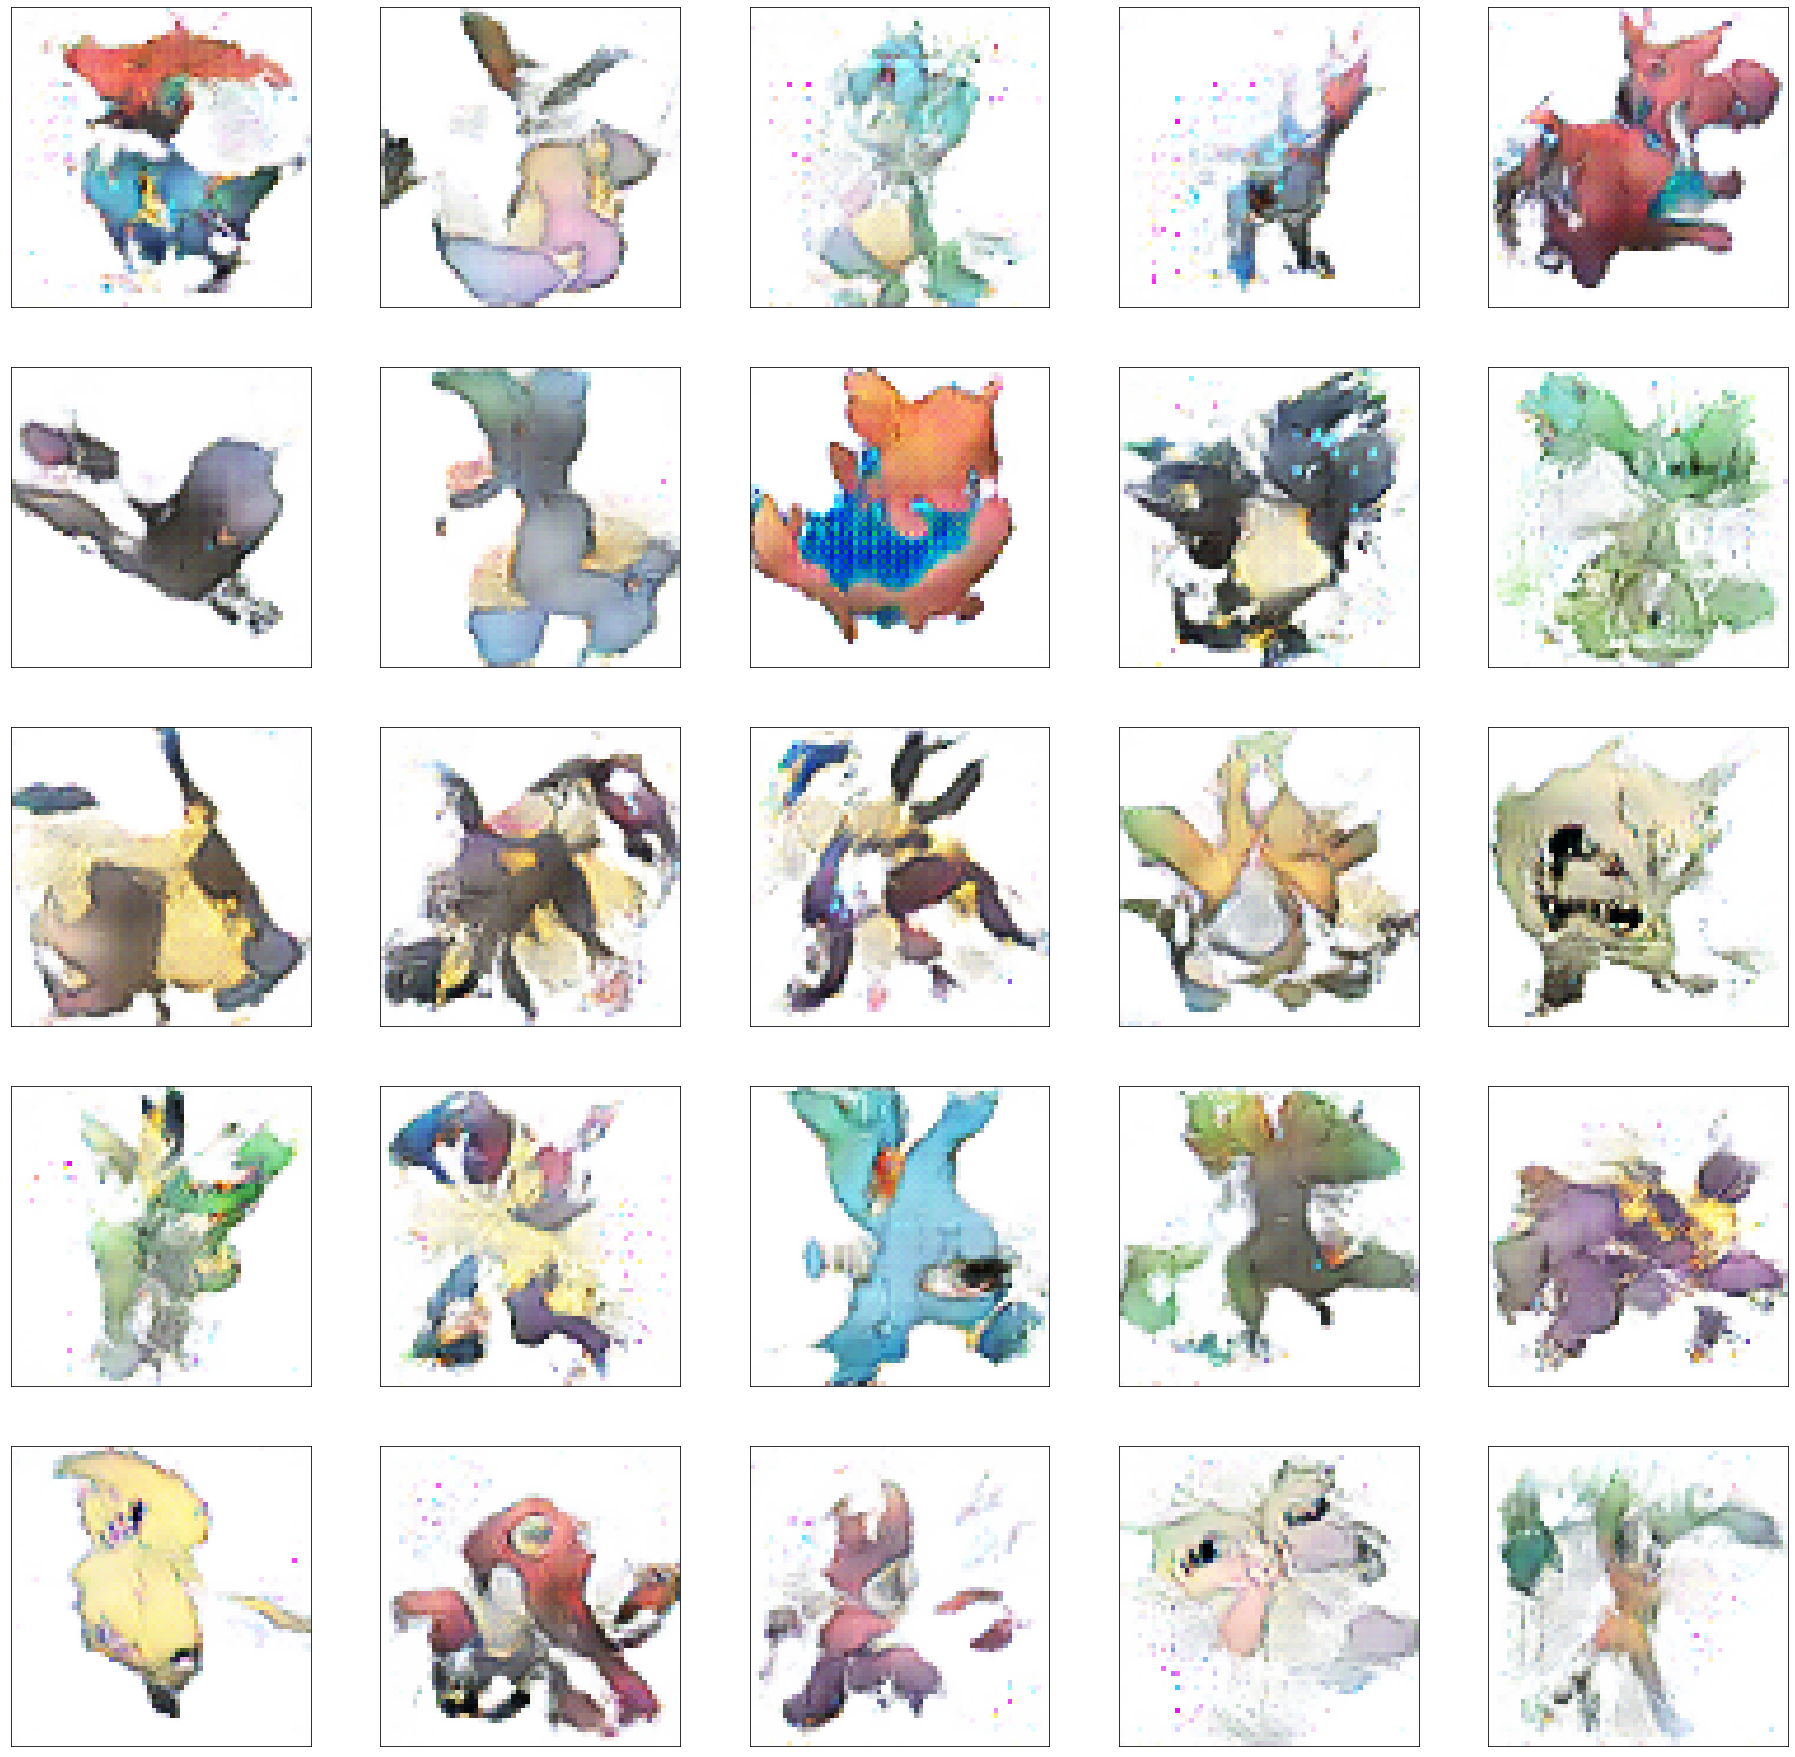

In [24]:
# Ploting generated image for specific type
# 0: Bug, 1: Dark, 2: Dragon, 3: Electric, 4: Fairy, 5: Fighting, 6: Fire, 7: Flying, 8: Ghost
# 9: Grass, 10: Ground, 11: Ice, 12: Normal, 13: Poison, 14: Psychic, 15: Rock, 16: Steel, 17: Water

pokemon_type_select = 6

element_noise = torch.randn(25, nz, device=device)
element_label = np.zeros((25, 18))
element_label = element_label.tolist()
for i in range(25):
  element_label[i][pokemon_type_select] = 1
element_label = torch.Tensor(element_label).to(device)
element_label = torch.cat([element_label])
fake_element_images = netG(element_noise, element_label)

view_samples2(fake_element_images, 5, 5, ngf, ngf)